# Imports

In [16]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time as time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat
import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor
import pickle
from sklearn.model_selection import ShuffleSplit
import transformers
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from torchmetrics.classification import BinaryAccuracy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
# if you are using a mac this cell aims to solve this error: 
# NotImplementedError: The operator 'aten::scatter_reduce.two_out' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable ⁠ PYTORCH_ENABLE_MPS_FALLBACK=1 ⁠ to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

# You will probably need first to execute this bash command in your terminal: touch .zshenv && echo 'export PYTORCH_ENABLE_MPS_FALLBACK=1' >> .zshenv
# And then restart the notebook

#import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# MODELE

In [2]:


class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')


class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()

        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)

        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5)
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)

    def forward(self, x, edge_index, edge_attr, batch):
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x



class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, segment, age
    """

    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        #self.word_embeddings = nn.Linear(config.vocab_size, config.hidden_size)
        self.word_embeddings = GraphTransformer(config)
        self.type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size//5)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.age_vocab_size, config.hidden_size//5))
        self.time_embeddings = nn.Embedding(config.time_vocab_size , config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.time_vocab_size, config.hidden_size//5))
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size//5). \
            from_pretrained(embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size//5))


        self.seq_layers = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Dropout(config.hidden_dropout_prob),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU(),
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.GELU()
        )

        self.LayerNorm = nn.LayerNorm(config.hidden_size)
        self.acti = nn.GELU()
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

    def forward(self, nodes, edge_index,  edge_attr, batch, age_ids, time_ids,  type_ids, posi_ids):
        word_embed = self.word_embeddings(nodes, edge_index, edge_attr, batch)
        type_embeddings = self.type_embeddings(type_ids)
        age_embed = self.age_embeddings(age_ids)
        time_embeddings = self.time_embeddings(time_ids)
        posi_embeddings = self.posi_embeddings(posi_ids)

        word_embed = torch.reshape(word_embed, type_embeddings.shape)
        embeddings = torch.cat((word_embed, type_embeddings, posi_embeddings, age_embed, time_embeddings), dim=2)
        
        b, n, _ = embeddings.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        embeddings = torch.cat((cls_tokens, embeddings), dim=1)
        embeddings = self.seq_layers(embeddings)
        embeddings = self.LayerNorm(embeddings)
        
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        def even_code(pos, idx):
            return np.sin(pos / (10000 ** (2 * idx / hidden_size)))

        def odd_code(pos, idx):
            return np.cos(pos / (10000 ** (2 * idx / hidden_size)))

        # initialize position embedding table
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)

        # reset table parameters with hard encoding
        # set even dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(0, hidden_size, step=2):
                lookup_table[pos, idx] = even_code(pos, idx)
        # set odd dimension
        for pos in range(max_position_embedding):
            for idx in np.arange(1, hidden_size, step=2):
                lookup_table[pos, idx] = odd_code(pos, idx)

        return torch.tensor(lookup_table)



class BertModel(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config=config)
        self.encoder = Bert.modeling.BertEncoder(config=config)
        self.pooler = Bert.modeling.BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, output_all_encoded_layers=True):

        if attention_mask is None:
            attention_mask = torch.ones_like(age_ids)

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output, extended_attention_mask, output_all_encoded_layers=output_all_encoded_layers)
        
        sequence_output = encoded_layers[-1]

        pooled_output = self.pooler(sequence_output)
        
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        return encoded_layers, pooled_output




class BertForMTR(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super(BertForMTR, self).__init__(config)
        self.num_labels = 1
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask=None, labels=None):
        encoded_layer, pooled_output = self.bert(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attention_mask, output_all_encoded_layers=False)
        logits = self.classifier(pooled_output).squeeze(dim=1)

        weights = torch.where(labels == 1, torch.tensor(2), torch.tensor(1.0))  # more important weight in the loss for the patients that die
        bce_logits_loss = nn.BCEWithLogitsLoss(reduction='mean', weight=weights)
        discr_supervised_loss = bce_logits_loss(logits, labels)
        
        return encoded_layer, pooled_output, logits, discr_supervised_loss
    



class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')



class TrainConfig(object):
    def __init__(self, config):
        self.batch_size = config.get('batch_size')
        self.max_len_seq = config.get('max_len_seq')
        self.train_loader_workers = config.get('train_loader_workers')
        self.test_loader_workers = config.get('test_loader_workers')
        self.device = config.get('device')
        self.output_dir = config.get('output_dir')
        self.output_name = config.get('output_name')
        self.best_name = config.get('best_name')



class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

# DATA

In [3]:
path = '../../data/'
path_results = '../../results/'

In [4]:
with open(path + 'data_pad_after_min2.pkl', 'rb') as handle:
    dataset_loaded = pickle.load(handle)

In [5]:
dataset=dataset_loaded

In [6]:
print(len(dataset))
print(len(dataset[0]))
print(dataset[0][-1])

100
50
Data(subject_id=[1], hadm_id=[1], label=[1], age=[1], rang=[1], type=[1], x=[56], edge_index=[2, 1540], edge_attr=[1540], mask_v=[1], time=[1])


In [7]:
noeud_unique = set()
edge_attr_unique = set()
age_unique = set()
time_unique = set()
type_unique = set()
label_unique = set()
hadm_unique = set()
subject_unique = set()
mask_v_unique = set()
rang_unique = set()
for patient in dataset:
    for visite in patient:
        noeuds = visite.x.tolist()
        edge = visite.edge_attr.tolist()
        label = visite.label.tolist()
        age = visite.age.tolist()
        time = visite.time.tolist()
        typ = visite.type.tolist()
        mask_v = visite.mask_v.tolist()
        rang = visite.rang.tolist()
        hadm = visite.hadm_id.tolist()
        subject = visite.subject_id.tolist()
        for noeud in noeuds:
            noeud_unique.add(noeud)
        for attribut in edge:
            edge_attr_unique.add(attribut)
        for lab in label:
            label_unique.add(lab)
        for a in age:
            age_unique.add(a)
        for t in time:
            time_unique.add(t)
        for ty in typ:
            type_unique.add(ty)
        for mask in mask_v:
            mask_v_unique.add(mask)
        for r in rang:
            rang_unique.add(r)
        for h in hadm:
            hadm_unique.add(h)
        for s in subject:
            subject_unique.add(s)
        

vocab_size = len(noeud_unique)
edge_attr_size = len(edge_attr_unique)
age_size = len(age_unique)
time_size = len(time_unique)
type_size = len(type_unique)
label_size = len(label_unique)
hadm_size = len(hadm_unique)
subject_size = len(subject_unique)
mask_v_size = len(mask_v_unique)
rang_size = len(rang_unique)

print('vocab_size',vocab_size)
print('max noeud',max(noeud_unique))
print('node_attr_size',edge_attr_size)
print('max edge_attr',max(edge_attr_unique))
print('age_size',age_size)
print('max age',max(age_unique))
print('time_size',time_size)
print('max time',max(time_unique))
print('type_size',type_size)
print('max type',max(type_unique))
print('label_size',label_size)
print('max label',max(label_unique))
print('hadm_size',hadm_size)
print('subject_size',subject_size)
print('maskv_size',mask_v_size)
print('max maskv',max(mask_v_unique))
print('rang_size',rang_size)
print('max rang',max(rang_unique))

vocab_size 1055
max noeud 9377
node_attr_size 8
max edge_attr 7
age_size 48
max age 130
time_size 248
max time 367
type_size 9
max type 10
label_size 2
max label 1
hadm_size 394
subject_size 100
maskv_size 2
max maskv 1
rang_size 24
max rang 51


In [8]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]

      return trainDSet, valDSet, testDSet

# Config file 

In [9]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    #'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'device': "cpu",
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 15,
    'lr': 0.0001,
    'weight_decay': 0.0001,
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1, # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels': 1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

# fonction entrainement

In [29]:
def train(model, optim_model, trainload, device):
    tr_loss = 0
    start = time.time()
    model.train()

    for step, data in tqdm(enumerate(trainload)):
        optim_model.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch
        
        age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
        time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
        type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
        posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
        attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
        attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
        labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, -1].float()

        _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)

        loss.backward()
        tr_loss += loss.item()
        optim_model.step()
        del loss
    
    print("TOTAL TRAIN LOSS",(tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    print("TRAINING TIME", cost)

    return tr_loss, cost


def eval(model, optim_model, _valload, saving, device):
    tr_loss = 0
    start = time.time()
    model.eval()
    all_labels = []
    all_logits = []
    all_pred = []
    sig = nn.Sigmoid()
    with torch.no_grad():
        for step, data in enumerate(_valload):
            optim_model.zero_grad()

            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, 0].float()

            _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids,type_ids,posi_ids,attMask, labels)

            tr_loss += loss.item()
            del loss

            pred = np.where(sig(logits).cpu().detach().numpy() > 0.5, 1, 0)
            all_pred.extend(pred)
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("TOTAL VAL LOSS",(tr_loss * train_params['batch_size']) / len(_valload))
    accuracy = skm.accuracy_score(all_labels, all_pred)

    cost = time.time() - start
    print("EVAL TIME", cost)

    return tr_loss, cost, accuracy


def test(testload, model, device):
    model.eval()
    tr_loss = 0
    start = time.time()
    all_labels = []
    all_logits = []
    all_pred = []

    with torch.no_grad():
        for step, data in enumerate(testload):
            # Process the batch data and move it to the device
            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)

            # Extract relevant data from the batch
            nodes = graph_batch.x
            edge_index = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            # extract age, time, type, posi, mask, label
            age_ids = torch.reshape(graph_batch.age, [graph_batch.age.shape[0] // 50, 50])
            time_ids = torch.reshape(graph_batch.time, [graph_batch.time.shape[0] // 50, 50])
            type_ids = torch.reshape(graph_batch.type, [graph_batch.type.shape[0] // 50, 50])
            posi_ids = torch.reshape(graph_batch.posi_ids, [graph_batch.posi_ids.shape[0] // 50, 50])
            attMask = torch.reshape(graph_batch.mask_v, [graph_batch.mask_v.shape[0] // 50, 50])
            attMask = torch.cat((torch.ones((attMask.shape[0], 1)).to(device), attMask), dim=1)
            labels = torch.reshape(graph_batch.label, [graph_batch.label.shape[0] // 50, 50])[:, 0].float()

            # Forward pass
            _, _, logits, loss = model(nodes, edge_index, edge_attr, batch, age_ids, time_ids, type_ids, posi_ids, attMask, labels)

            tr_loss += loss.item()
            del loss

            pred = torch.sigmoid(logits)
            all_pred.extend(pred.detach().cpu().numpy())
            # Accumulate logits, labels for later evaluation
            all_logits.extend(logits.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("TOTAL TEST LOSS ", (tr_loss * train_params['batch_size']) / len(testload))
    cost = time.time() - start
    print("TEST TEST TIME", cost)
    
    predicted_probabilities = [torch.sigmoid(torch.tensor(l)) for l in all_logits]
    auroc = roc_auc_score(all_labels, predicted_probabilities)
    precision, recall, thresholds = precision_recall_curve(all_labels, predicted_probabilities)   
    auprc = auc(recall, precision)
    
    threshold = 0.5
    predicted_labels = [1 if l > threshold else 0 for l in all_logits]
    f1 = f1_score(all_labels, predicted_labels, average='weighted')
    accuracy = skm.accuracy_score(all_labels, predicted_labels)

    return auroc, auprc, f1, accuracy, cost



def run_epoch(model, optim_model, trainload, valload, device, exp):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []

    for e in range(train_params["epochs"]):
        print("Epoch n" + str(e))

        train_loss, train_time_cost = train(model, optim_model, trainload, device)
        val_loss, val_time_cost, accuracy = eval(model, optim_model, valload, False, device)

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        
        with open(path_results + 'losses_and_times/' + "GT_behrt_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            model_to_save = model.module if hasattr(model, 'module') else model
            torch.save(model_to_save.state_dict(), path_results + 'weights/' + 'GT_bert_num_' + f'{exp}' + '.pch')
            # sauvegarder les parametre du model
            best_val = val_loss
        print('\n')


    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'GT_bert.png')
    plt.show()

    return train_loss, val_loss, accuracy, train_time_cost, val_time_cost



def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = BertForMTR(conf).to(train_params['device'])
        
        # taking back the weights of the pretraining 2
        model.load_state_dict(torch.load(path_results + 'weights/' + 'GraphTransformer_pretrain_2_num_' + f'{exp}' + '.pch', map_location=train_params.get('device')))
        
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])
        scheduler = None
    
        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload =  GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False) 
        valload =  GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)
        testload =  GraphLoader(GDSet(testDSet), batch_size=train_params['batch_size'], shuffle=False)

        #pretrain à ajouter ici
        train_loss, val_loss, accuracy_val ,train_time_cost, val_time_cost= run_epoch(model, optim_model, trainload, valload, train_params['device'], exp)
        auc_roc, aupcr, f1, accuracy_test, cost = test(testload, model, train_params['device'])

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test AUROC', auc_roc]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test AUPRC', aupcr]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test F1', f1]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Accuracy', accuracy_val]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Accuracy', accuracy_test]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Test Time', cost]
        
    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results.csv')

    return df, model



# Main

  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  8.60it/s]


 Experiment 1
Epoch n0



3it [00:00,  9.03it/s]
5it [00:00,  9.67it/s]
6it [00:00,  9.63it/s]
7it [00:00,  9.57it/s]
8it [00:00,  9.58it/s]
10it [00:01,  8.98it/s]
12it [00:01,  9.60it/s]
13it [00:01,  9.54it/s]
15it [00:01,  9.89it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.3231103320916495
TRAINING TIME 1.5183680057525635
TOTAL VAL LOSS 2.9489926993846893
EVAL TIME 0.058181047439575195
** ** * Saving fine - tuned model ** ** * 


Epoch n1



1it [00:00,  7.63it/s]
3it [00:00,  8.21it/s]
5it [00:00,  8.94it/s]
6it [00:00,  8.93it/s]
7it [00:00,  8.86it/s]
8it [00:00,  8.94it/s]
10it [00:01,  8.60it/s]
12it [00:01,  9.21it/s]
13it [00:01,  9.42it/s]
15it [00:01,  9.68it/s]

0it [00:00, ?it/s]
1it [00:00,  9.44it/s]

TOTAL TRAIN LOSS 3.223714917898178
TRAINING TIME 1.5510289669036865
TOTAL VAL LOSS 2.930605262517929
EVAL TIME 0.05234193801879883
** ** * Saving fine - tuned model ** ** * 


Epoch n2



3it [00:00,  9.54it/s]
5it [00:00,  9.90it/s]
6it [00:00,  9.57it/s]
7it [00:00,  9.30it/s]
8it [00:00,  9.26it/s]
10it [00:01,  8.91it/s]
12it [00:01,  9.47it/s]
13it [00:01,  9.41it/s]
15it [00:01,  9.72it/s]


TOTAL TRAIN LOSS 3.2507387697696686
TRAINING TIME 1.5438673496246338
TOTAL VAL LOSS 2.9441413283348083
EVAL TIME 0.05110812187194824


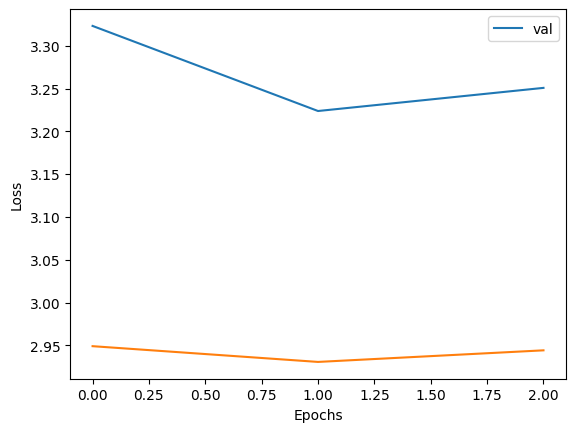

 20%|██        | 1/5 [00:05<00:20,  5.16s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  2.8008894622325897
TEST TEST TIME 0.1350090503692627

 Experiment 2
Epoch n0



2it [00:00, 10.14it/s]
4it [00:00, 10.39it/s]
5it [00:00, 10.26it/s]
6it [00:00,  9.87it/s]
8it [00:00, 10.18it/s]
9it [00:00,  8.77it/s]
10it [00:01,  8.86it/s]
11it [00:01,  9.12it/s]
12it [00:01,  9.21it/s]
15it [00:01, 10.14it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.204754372437795
TRAINING TIME 1.480443000793457
TOTAL VAL LOSS 3.8028281927108765
EVAL TIME 0.06152987480163574
** ** * Saving fine - tuned model ** ** * 


Epoch n1



2it [00:00, 10.48it/s]
4it [00:00, 10.73it/s]
6it [00:00, 10.65it/s]
8it [00:00, 10.70it/s]
9it [00:00,  9.01it/s]
10it [00:00,  9.25it/s]
12it [00:01,  9.56it/s]
15it [00:01, 10.59it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.1194505592187247
TRAINING TIME 1.4174408912658691
TOTAL VAL LOSS 3.8696137070655823
EVAL TIME 0.0612030029296875


Epoch n2



2it [00:00, 10.69it/s]
4it [00:00, 10.82it/s]
6it [00:00, 10.70it/s]
8it [00:00, 10.77it/s]
9it [00:00,  9.17it/s]
10it [00:00,  9.35it/s]
12it [00:01,  9.66it/s]
15it [00:01, 10.64it/s]

TOTAL TRAIN LOSS 3.1239288250605264
TRAINING TIME 1.4111509323120117
TOTAL VAL LOSS 3.8336269557476044
EVAL TIME 0.05320096015930176


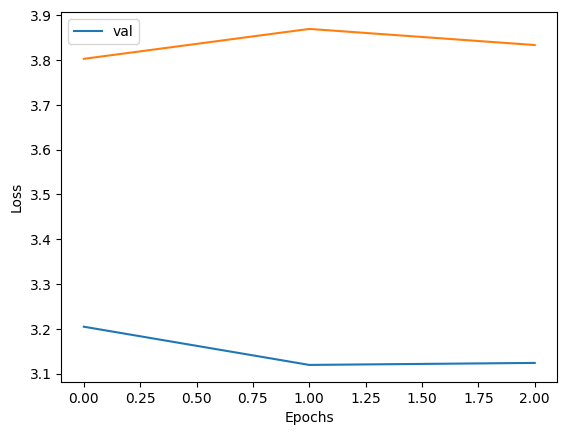

 40%|████      | 2/5 [00:10<00:15,  5.07s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  2.7874090522527695
TEST TEST TIME 0.14055705070495605

 Experiment 3
Epoch n0



2it [00:00, 11.12it/s]
4it [00:00, 10.52it/s]
6it [00:00, 10.73it/s]
7it [00:00, 10.37it/s]
9it [00:00, 10.18it/s]
11it [00:01, 10.31it/s]
13it [00:01, 10.23it/s]
15it [00:01, 10.45it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.248590553800265
TRAINING TIME 1.4368829727172852
TOTAL VAL LOSS 3.2815371081233025
EVAL TIME 0.06650209426879883
** ** * Saving fine - tuned model ** ** * 


Epoch n1



2it [00:00, 10.92it/s]
3it [00:00, 10.48it/s]
4it [00:00,  9.70it/s]
6it [00:00, 10.05it/s]
7it [00:00, 10.02it/s]
9it [00:00, 10.08it/s]
10it [00:00, 10.00it/s]
12it [00:01, 10.23it/s]
13it [00:01,  9.98it/s]
15it [00:01, 10.40it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 2.9457099785407386
TRAINING TIME 1.4441871643066406
TOTAL VAL LOSS 3.2809075713157654
EVAL TIME 0.06093788146972656
** ** * Saving fine - tuned model ** ** * 


Epoch n2



2it [00:00, 11.45it/s]
3it [00:00, 10.94it/s]
4it [00:00,  9.95it/s]
6it [00:00, 10.28it/s]
7it [00:00, 10.12it/s]
9it [00:00, 10.13it/s]
11it [00:01, 10.20it/s]
13it [00:01, 10.16it/s]
15it [00:01, 10.52it/s]


TOTAL TRAIN LOSS 2.9304836293061576
TRAINING TIME 1.4266231060028076
TOTAL VAL LOSS 3.2591843605041504
EVAL TIME 0.055451154708862305
** ** * Saving fine - tuned model ** ** * 


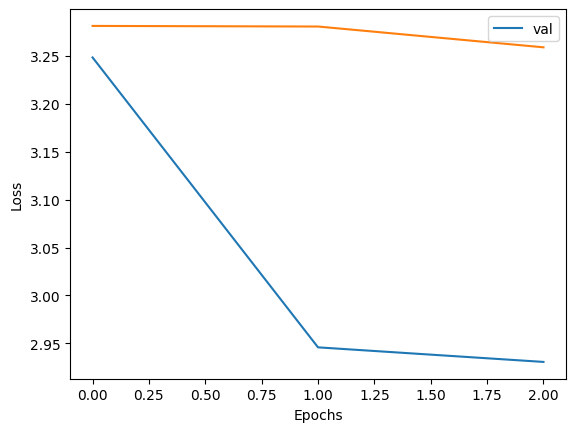

 60%|██████    | 3/5 [00:14<00:10,  5.02s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  4.24988679587841
TEST TEST TIME 0.15360212326049805

 Experiment 4
Epoch n0



2it [00:00, 10.98it/s]
3it [00:00, 10.41it/s]
5it [00:00, 10.49it/s]
6it [00:00,  9.92it/s]
7it [00:00,  9.93it/s]
9it [00:00,  9.58it/s]
10it [00:01,  9.55it/s]
12it [00:01,  9.94it/s]
15it [00:01, 10.03it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.4719921549161277
TRAINING TIME 1.4964590072631836
TOTAL VAL LOSS 1.8089934438467026
EVAL TIME 0.05168008804321289
** ** * Saving fine - tuned model ** ** * 


Epoch n1



2it [00:00, 10.77it/s]
3it [00:00, 10.34it/s]
5it [00:00, 10.34it/s]
6it [00:00, 10.00it/s]
8it [00:00, 10.27it/s]
9it [00:00,  9.15it/s]
10it [00:01,  9.03it/s]
12it [00:01,  9.49it/s]
15it [00:01,  9.88it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.3990347385406494
TRAINING TIME 1.518812894821167
TOTAL VAL LOSS 1.642771065235138
EVAL TIME 0.0565338134765625
** ** * Saving fine - tuned model ** ** * 


Epoch n2



2it [00:00, 11.07it/s]
3it [00:00, 10.42it/s]
5it [00:00, 10.38it/s]
6it [00:00,  9.90it/s]
8it [00:00, 10.04it/s]
9it [00:00,  8.93it/s]
10it [00:01,  9.14it/s]
12it [00:01,  9.70it/s]
15it [00:01, 10.00it/s]

TOTAL TRAIN LOSS 3.415649781624476
TRAINING TIME 1.5005908012390137
TOTAL VAL LOSS 1.67026087641716
EVAL TIME 0.05009007453918457


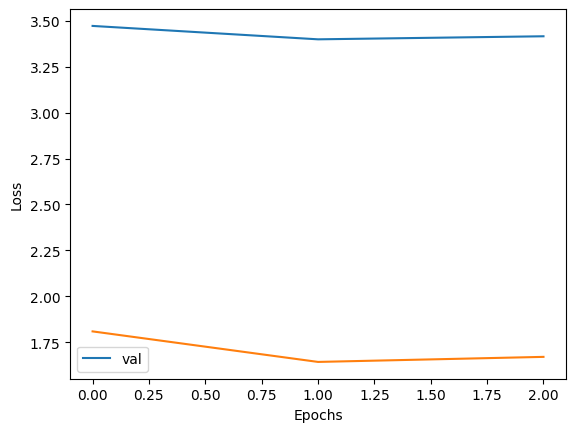

 80%|████████  | 4/5 [00:19<00:05,  5.03s/it]
0it [00:00, ?it/s]

TOTAL TEST LOSS  3.2192115113139153
TEST TEST TIME 0.13420391082763672

 Experiment 5
Epoch n0



2it [00:00, 11.09it/s]
4it [00:00, 10.58it/s]
6it [00:00,  9.78it/s]
8it [00:00, 10.05it/s]
10it [00:01, 10.21it/s]
11it [00:01,  9.59it/s]
13it [00:01, 10.03it/s]
15it [00:01, 10.46it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.580237885316213
TRAINING TIME 1.4352562427520752
TOTAL VAL LOSS 4.655777961015701
EVAL TIME 0.058828115463256836
** ** * Saving fine - tuned model ** ** * 


Epoch n1



2it [00:00, 11.40it/s]
4it [00:00, 10.65it/s]
6it [00:00,  9.88it/s]
8it [00:00, 10.02it/s]
10it [00:01, 10.29it/s]
11it [00:01, 10.08it/s]
13it [00:01, 10.37it/s]
15it [00:01, 10.49it/s]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.2628484964370728
TRAINING TIME 1.4310662746429443
TOTAL VAL LOSS 4.618619680404663
EVAL TIME 0.05359077453613281
** ** * Saving fine - tuned model ** ** * 


Epoch n2



2it [00:00, 11.54it/s]
3it [00:00, 11.00it/s]
4it [00:00,  9.94it/s]
6it [00:00,  9.35it/s]
8it [00:00,  9.80it/s]
10it [00:01, 10.09it/s]
11it [00:01,  9.85it/s]
13it [00:01, 10.29it/s]
15it [00:01, 10.47it/s]


TOTAL TRAIN LOSS 3.2488413651784263
TRAINING TIME 1.4338698387145996
TOTAL VAL LOSS 4.562436640262604
EVAL TIME 0.06128716468811035
** ** * Saving fine - tuned model ** ** * 


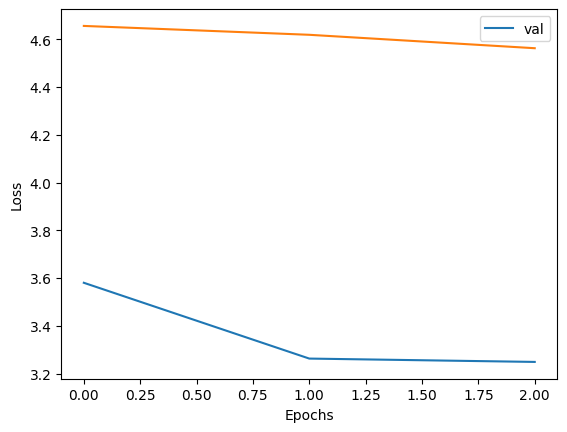

100%|██████████| 5/5 [00:24<00:00,  4.97s/it]

TOTAL TEST LOSS  2.0151983574032784
TEST TEST TIME 0.1358950138092041


In [30]:
df, model = experiment(num_experiments=5)

In [31]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Test AUROC,0.509804
1,1,GT_BERT,Test AUPRC,0.176508
2,1,GT_BERT,Test F1,0.781081
3,1,GT_BERT,Val Accuracy,0.875000
4,1,GT_BERT,Test Accuracy,0.850000
5,1,GT_BERT,Train Loss,3.250739
6,1,GT_BERT,Val Loss,2.944141
7,1,GT_BERT,Train Time,1.543867
8,1,GT_BERT,Val Time,0.051108
9,1,GT_BERT,Test Time,0.135009


In [32]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# Print the result
result_df

,Model,Metric,Average Score,Standard Deviation
0,GT_BERT,Test AUPRC,0.25,0.14
1,GT_BERT,Test AUROC,0.68,0.17
2,GT_BERT,Test Accuracy,0.83,0.09
3,GT_BERT,Test F1,0.76,0.13
4,GT_BERT,Test Time,0.14,0.01
5,GT_BERT,Train Loss,3.19,0.18
6,GT_BERT,Train Time,1.46,0.06
7,GT_BERT,Val Accuracy,0.80,0.14
8,GT_BERT,Val Loss,3.25,1.08
9,GT_BERT,Val Time,0.05,0.00


In [33]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters())

count_parameters(model)

3834573

In [34]:
# saving results
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results.csv')